# Prediksi Harga Saham PT Telekomunikasi Indonesia Tbk (TLKM.JK) Menggunakan LSTM

## Latar Belakang
PT Telekomunikasi Indonesia Tbk (TLKM) adalah perusahaan telekomunikasi terbesar di Indonesia.
Harga sahamnya menjadi indikator penting bagi investor yang ingin memantau perkembangan sektor ini.
Dengan bantuan algoritma *Long Short-Term Memory (LSTM)*, kita dapat memprediksi harga saham berdasarkan data historis.

# Importing Needed Libraries

Pertama, kita mengimpor pustaka-pustaka penting yang akan digunakan untuk analisis data, visualisasi, dan pembangunan model:  

- **math** untuk operasi matematika dasar  
- **numpy (np)** dan **pandas (pd)** untuk manipulasi data numerik dan terstruktur  
- **seaborn (sns)** dan **matplotlib.pyplot (plt)** untuk visualisasi data dengan gaya yang telah dikonfigurasi  
- **keras** untuk membangun dan melatih model deep learning  
- **Sequential, LSTM, Dense, Dropout** dari Keras untuk arsitektur model jaringan saraf  
- **EarlyStopping** dari Keras untuk menghentikan pelatihan secara otomatis ketika model tidak mengalami peningkatan  
- **MinMaxScaler** dari scikit-learn untuk normalisasi data  
- **train_test_split** dari scikit-learn untuk membagi dataset  
- **mean_squared_error, mean_absolute_error, mean_absolute_percentage_error** dari scikit-learn untuk evaluasi performa model  

Berikut adalah kode implementasinya:  

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Reading and Understanding the Dataset


### About the Dataset  
Dataset ini berisi data historis saham **PT Telekomunikasi Indonesia Tbk (TLKM.JK)** yang diperdagangkan di **Bursa Efek Indonesia (BEI)** dari tahun **2019 hingga 2024**.  

### Kolom-kolom dalam Dataset:  
- **Date**: Tanggal pencatatan data (format: `DD/MM/YYYY`).  
- **Open**: Harga pembukaan saham di awal sesi perdagangan.  
- **High**: Harga tertinggi yang dicapai dalam satu hari perdagangan.  
- **Low**: Harga terendah yang dicapai dalam satu hari perdagangan.  
- **Close**: Harga penutupan saham di akhir sesi perdagangan.  
- **Adj Close**: Harga penutupan yang disesuaikan (termasuk dividen, stock split, dll.).  
- **Volume**: Jumlah saham yang diperdagangkan (dalam format angka dengan titik, perlu konversi ke numerik).  

Dataset terdiri dari **1.212 entri**, cocok untuk analisis tren, prediksi harga, dan pemodelan time series.  


## Memuat Dataset dari Kaggle  

### Langkah 1: Mengautentikasi Kaggle API  
Sebelum mengunduh dataset, pastikan **kaggle.json** (berisi API key) sudah diunggah.  

In [3]:
# Upload kaggle.json yang didapatkan dari akun Kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"naufalnurfahriza","key":"ec6f7ab7dabebc9fd0600384aa1880de"}'}

### Langkah 2: Konfigurasi Direktori Kaggle

In [4]:
# Buat direktori dan ubah izin file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### Langkah 3: Mengunduh Dataset  
Dataset diunduh dari:  
📌 [Kaggle: Dataset Saham TLKM.JK](https://www.kaggle.com/datasets/irfansaputranst/dataset-saham-tlkm-jk)  

In [5]:
# Download dataset dari Kaggle
!kaggle datasets download -d irfansaputranst/dataset-saham-tlkm-jk
# Unzip file ZIP hasil download
!unzip dataset-saham-tlkm-jk.zip

Dataset URL: https://www.kaggle.com/datasets/irfansaputranst/dataset-saham-tlkm-jk
License(s): DbCL-1.0
  0% 0.00/18.7k [00:00<?, ?B/s]
100% 18.7k/18.7k [00:00<00:00, 83.8MB/s]
Archive:  dataset-saham-tlkm-jk.zip
  inflating: SAHAM - PT Telekomunikasi Indonesia Tbk (TLKM.JK) - Sheet1.csv  


### Langkah 4: Membaca Dataset ke DataFrame  

In [6]:
import pandas as pd

# Muat dataset dan atur kolom 'Date' sebagai index
df = pd.read_csv(
    'SAHAM - PT Telekomunikasi Indonesia Tbk (TLKM.JK) - Sheet1.csv',
    parse_dates=['Date'],  # Otomatis konversi ke datetime
    index_col='Date'       # Gunakan 'Date' sebagai index
)

# Tampilkan 5 baris pertama
print(df.head())

            Adj Close   Close    High     Low    Open       Volume
Date                                                              
07/11/2019    3216.63  4070.0  4150.0  3990.0  4150.0  125.291.200
08/11/2019    3248.24  4110.0  4120.0  3990.0  4010.0   70.404.800
11/11/2019    3240.34  4100.0  4120.0  4040.0  4040.0   57.079.800
12/11/2019    3303.57  4180.0  4190.0  4050.0  4050.0   88.251.100
13/11/2019    3279.86  4150.0  4170.0  4100.0  4130.0   91.925.700


# Eksplorasi Dataset Saham TLKM

## **1. Memuat dan Membersihkan Data**
Dataset saham TLKM dimuat dari file CSV dengan kolom `Date` dijadikan sebagai indeks. Kolom `Volume` dibersihkan dengan menghilangkan tanda titik (.) dan dikonversi ke tipe numerik.

## Statistik Deskriptif
Menampilkan informasi ringkas tentang jumlah data, tipe data, dan apakah ada nilai yang hilang.

In [7]:
import pandas as pd

# Memuat dataset
df = pd.read_csv(
    'SAHAM - PT Telekomunikasi Indonesia Tbk (TLKM.JK) - Sheet1.csv',
    parse_dates=['Date'],  # Mengonversi kolom 'Date' ke format datetime
    index_col='Date'       # Menggunakan 'Date' sebagai indeks
)

# Membersihkan kolom 'Volume' (format angka dengan titik)
df['Volume'] = df['Volume'].str.replace('.', '', regex=False).astype(float)



## **2. Statistik Deskriptif**
### **Menampilkan Informasi Dataset**
Fungsi `df.info()` memberikan ringkasan tentang struktur dataset, termasuk:
- Jumlah entri (**1.212 data**)
- Kolom-kolom yang ada (`Adj Close`, `Close`, `High`, `Low`, `Open`, `Volume`)
- Tipe data masing-masing kolom (semua numerik `float64`)
- Tidak ada nilai yang hilang (**Non-Null Count = 1.212**)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1212 entries, 07/11/2019 to 06/11/2024
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1212 non-null   float64
 1   Close      1212 non-null   float64
 2   High       1212 non-null   float64
 3   Low        1212 non-null   float64
 4   Open       1212 non-null   float64
 5   Volume     1212 non-null   float64
dtypes: float64(6)
memory usage: 66.3+ KB


### **Deskripsi Statistik Numerik**
Fungsi `df.describe()` memberikan gambaran statistik seperti:
- **Rata-rata (mean)**: Harga saham TLKM berkisar di **Rp 3.232 (Adj Close)** hingga **Rp 3.690 (High)**.
- **Standar deviasi (std)**: Variasi harga cukup tinggi (~Rp 500).
- **Nilai minimum/maksimum**:
  - Harga terendah (`Low`) = **Rp 2.450**
  - Harga tertinggi (`High`) = **Rp 4.850**
  - Volume perdagangan maksimal = **1,15 miliar saham**.
- **Quartile (25%, 50%, 75%)**: Menunjukkan distribusi data.

In [9]:
df.describe()

,Adj Close,Close,High,Low,Open,Volume
count,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1.212000e+03
mean,3232.919909,3647.978548,3690.998350,3607.483498,3650.981848,1.161022e+08
std,506.366462,510.865708,508.614228,508.024318,508.843617,7.744300e+07
min,2070.660000,2560.000000,2590.000000,2450.000000,2550.000000,0.000000e+00
25%,2835.450000,3190.000000,3250.000000,3150.000000,3200.000000,6.933892e+07
50%,3228.050000,3720.000000,3765.000000,3690.000000,3720.000000,9.611110e+07
75%,3666.010000,4030.000000,4060.000000,3990.000000,4030.000000,1.395841e+08
max,4295.700000,4770.000000,4850.000000,4720.000000,4850.000000,1.155861e+09


## **3. Analisis Korelasi Antar Variabel**
### **Heatmap Korelasi**
Korelasi dihitung menggunakan `df.corr()` dan divisualisasikan dengan **heatmap** untuk melihat hubungan antar variabel:
- **Harga (`Open`, `Close`, `High`, `Low`) memiliki korelasi sangat kuat (>0.99)**, artinya pergerakan harga sangat terkait.
- **Volume perdagangan memiliki korelasi lemah (~0.1) dengan harga**, menunjukkan volume tidak selalu memengaruhi harga langsung.

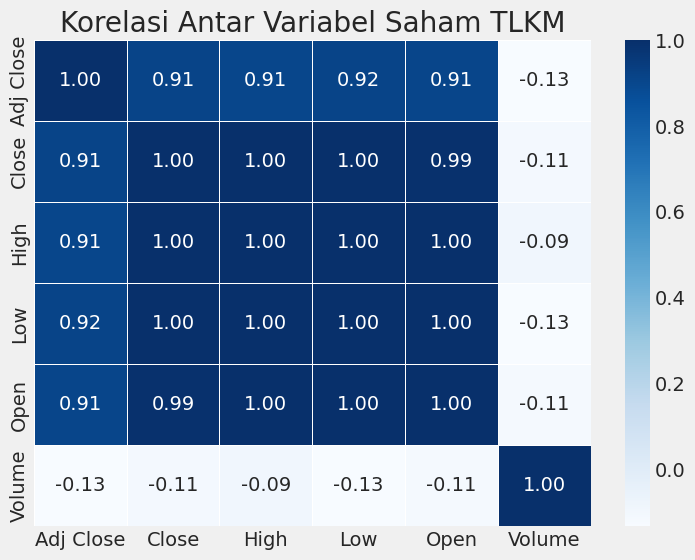

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(
    df.corr(),
    annot=True,       # Menampilkan nilai korelasi
    cmap='Blues',     # Warna biru gradien
    fmt='.2f',        # Format 2 angka desimal
    linewidths=0.5    # Garis pemisah antar sel
)
plt.title("Korelasi Antar Variabel Saham TLKM")
plt.show()


### **Interpretasi Korelasi:**
- **`Open`, `Close`, `High`, `Low` → Korelasi ≈ 1.00**  
  → Harga pembukaan, penutupan, tertinggi, dan terendah sangat berkaitan.
- **`Volume` vs Harga → Korelasi < 0.2**  
  → Volume perdagangan tidak selalu memengaruhi harga saham TLKM secara signifikan.

# **Visualisasi Data Saham TLKM**

## **1. Pergerakan Harga Saham (High & Low)**
Visualisasi ini menunjukkan fluktuasi harga tertinggi (`High`) dan terendah (`Low`) saham TLKM dari 2019 hingga 2024

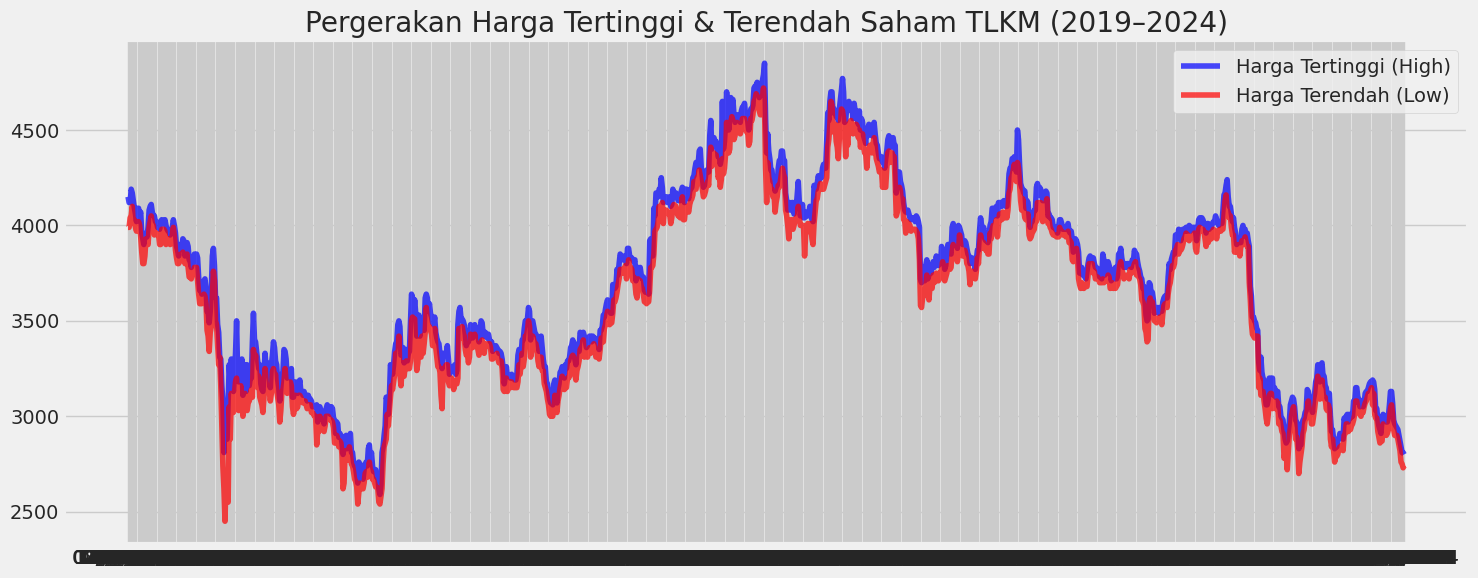

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))  # Ukuran gambar diperbesar
plt.plot(df.index, df['High'], label='Harga Tertinggi (High)', color='blue', alpha=0.7)
plt.plot(df.index, df['Low'], label='Harga Terendah (Low)', color='red', alpha=0.7)

plt.title('Pergerakan Harga Tertinggi & Terendah Saham TLKM (2019–2024)')
plt.xlabel(None)
plt.ylabel(None)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Penjelasan**:  
- **Tren**: Terlihat pola naik-turun yang konsisten, dengan puncak tertinggi di atas **Rp 4.800** dan terendah di sekitar **Rp 2.500**.  
- **Volatilitas**: Rentang harian (`High` vs `Low`) cukup lebar, terutama pada periode 2020 (pandemi) dan 2023-2024.  
- **Insight**: Saham TLKM cenderung stabil dengan kenaikan signifikan di akhir 2023.

## **2. Volume Perdagangan Saham**

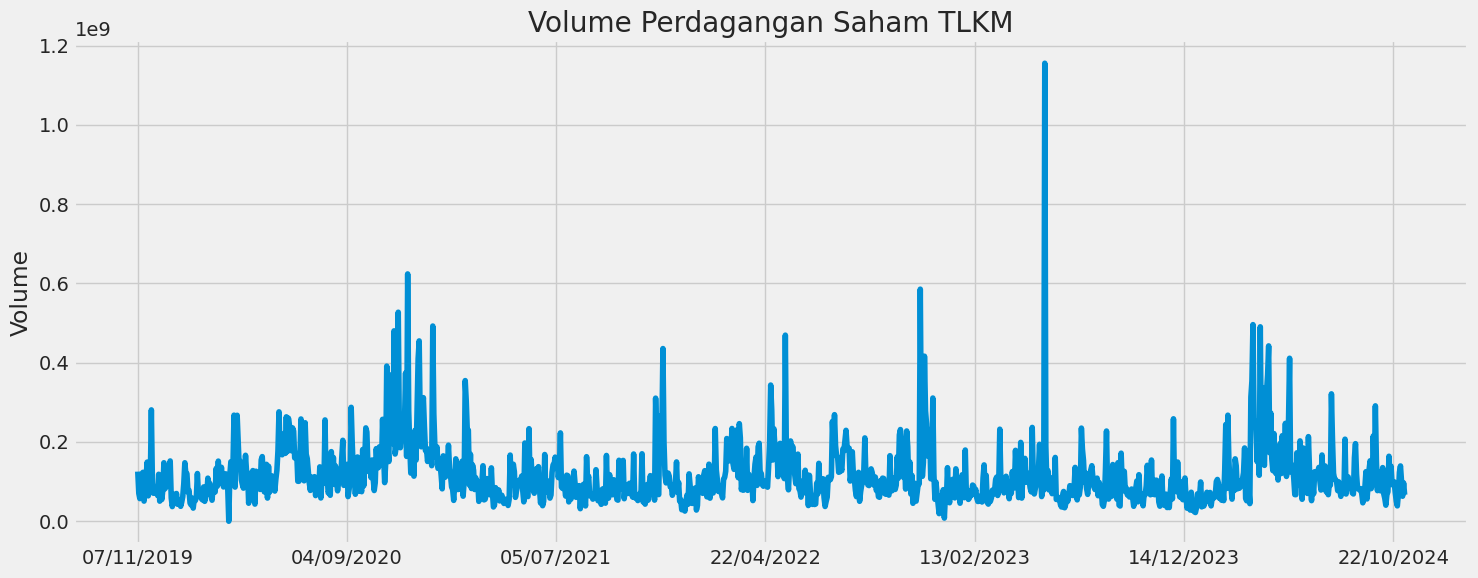

In [16]:
plt.figure(figsize=(15, 6))
df['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title("Volume Perdagangan Saham TLKM")
plt.tight_layout()
plt.show()

**Penjelasan**:  
- Volume perdagangan menunjukkan pola musiman dengan beberapa lonjakan signifikan.  
- Terdapat beberapa outlier volume yang sangat tinggi (>800 juta saham).  
- Periode 2022-2023 menunjukkan peningkatan aktivitas perdagangan.
- Baseline volume normal sekitar 50-200 juta saham per hari.

# **Preprocessing Data untuk Model LSTM**

## **1. Normalisasi Data**

In [17]:
# Mengambil kolom target ('Close') dan mengkonversi ke DataFrame
dataset = df[['Close']]  # Menggunakan [[]] untuk mempertahankan format DataFrame
data_values = dataset.values

# Normalisasi data ke range [0,1] menggunakan MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_values)

**Penjelasan**:
- Hanya menggunakan kolom `Close` sebagai target prediksi
- `MinMaxScaler` digunakan untuk menormalkan data ke range 0-1 yang lebih stabil untuk model LSTM
- Format data dipertahankan sebagai numpy array untuk konsistensi

## **2. Pembagian Data Train-Test**

In [18]:
# Membagi data menjadi train (80%) dan test (20%)
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

print(f"Train Size: {len(train_data)}")
print(f"Test Size: {len(test_data)}")

Train Size: 969
Test Size: 243


**Penjelasan**:
- Pembagian 80-20 untuk memastikan data latih yang cukup
- Tidak dilakukan shuffling untuk mempertahankan urutan temporal
- Test data diambil dari periode terakhir (paling baru)

## **3. Penyiapan Data Time Series**

In [20]:
# Fungsi untuk membuat dataset berbasis window time series
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])  # 60 time steps sebagai feature
        y.append(data[i, 0])              # Nilai berikutnya sebagai target
    return np.array(X), np.array(y)

# Membuat training set
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)

# Membuat test set
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input untuk LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (909, 60, 1)
y_train shape: (909,)
X_test shape: (183, 60, 1)
y_test shape: (183,)


**Penjelasan**:
- Setiap sampel terdiri dari 60 time steps (≈3 bulan trading) untuk memprediksi 1 step ke depan
- Data direshape ke format 3D yang dibutuhkan LSTM: [samples, timesteps, features]
- Jumlah sampel berkurang karena kebutuhan windowing

# **Modeling dan Evaluasi LSTM untuk Prediksi Harga Saham**

## **1. Arsitektur Model LSTM**

In [21]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,545 (205.25 KB)

 Trainable params: 52,545 (205.25 KB)

 Non-trainable params: 0 (0.00 B)

**Penjelasan Arsitektur**:
- **2 Layer LSTM** dengan 64 unit untuk menangkap pola temporal
- **Dropout 20%** untuk mencegah overfitting
- **3 Layer Dense** dengan aktivasi ReLU untuk pemrosesan non-linear
- Optimizer Adam dengan loss function MSE (Mean Squared Error)
- Metrik evaluasi MAE (Mean Absolute Error)


## **2. Pelatihan Model**

In [22]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.1581 - mean_absolute_error: 0.3056 - val_loss: 0.0195 - val_mean_absolute_error: 0.1241
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0104 - mean_absolute_error: 0.0828 - val_loss: 0.0055 - val_mean_absolute_error: 0.0574
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0062 - mean_absolute_error: 0.0590 - val_loss: 0.0038 - val_mean_absolute_error: 0.0494
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0062 - mean_absolute_error: 0.0601 - val_loss: 0.0035 - val_mean_absolute_error: 0.0487
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0059 - mean_absolute_error: 0.0587 - val_loss: 0.0035 - val_mean_absolute_error: 0.0474
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0051 - mean_absolute_error: 0.0544 - val_loss: 0.0042 - val_mean_absolute_error: 0.0495
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0050 - mean_absolute_error: 0.0539 - v

**Proses Pelatihan**:
- Early stopping untuk menghentikan pelatihan jika tidak ada perbaikan
- Validasi menggunakan 20% data test
- Batch size 32 untuk efisiensi komputasi
- Maksimal 100 epoch (biasanya berhenti lebih awal karena early stopping)

## **3. Evaluasi Model**

### **Visualisasi Loss dan MAE**

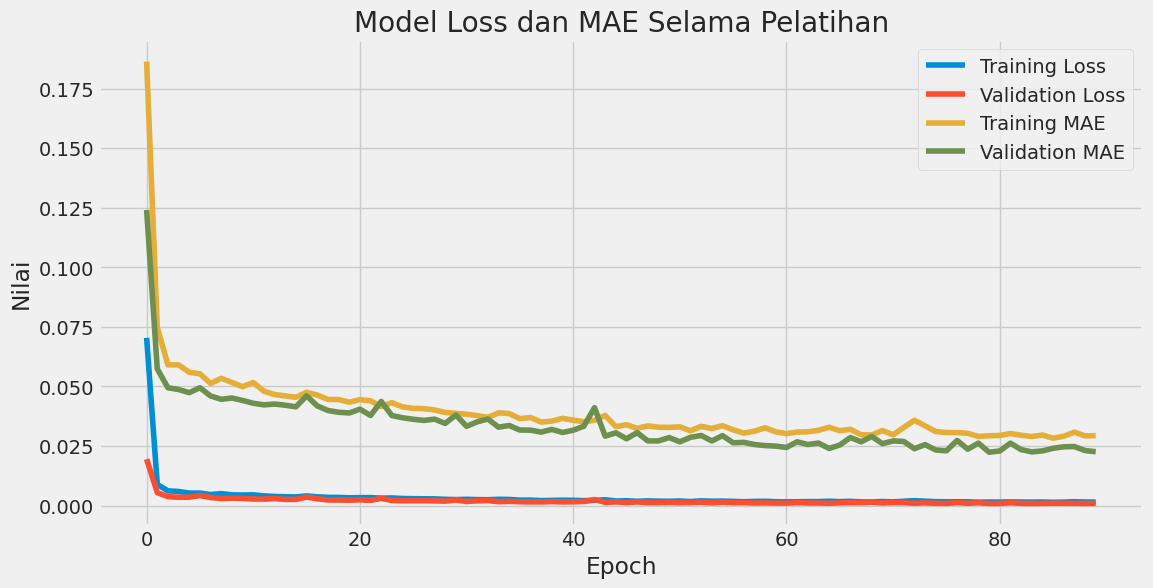

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model Loss dan MAE Selama Pelatihan')
plt.ylabel('Nilai')
plt.xlabel('Epoch')
plt.legend()
plt.show()


**Interpretasi**:
- Kurva training dan validation loss yang konvergen
- Tidak ada tanda overfitting (gap kecil antara training dan validation)
- MAE akhir di bawah 0.03 dalam skala normalisasi

### **Metrik Evaluasi Kuantitatif**

In [26]:
# Evaluasi pada test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

# Membuat prediksi
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

print(f"\nTest Loss (MSE): {test_loss:.6f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"MAE dalam Skala Aktual: {np.mean(np.abs(predictions - y_test_actual)):.2f} ")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Test Loss (MSE): 0.000883
Test MAE: 0.0224
MAE dalam Skala Aktual: 49.53 


## **4. Visualisasi Prediksi vs Aktual**

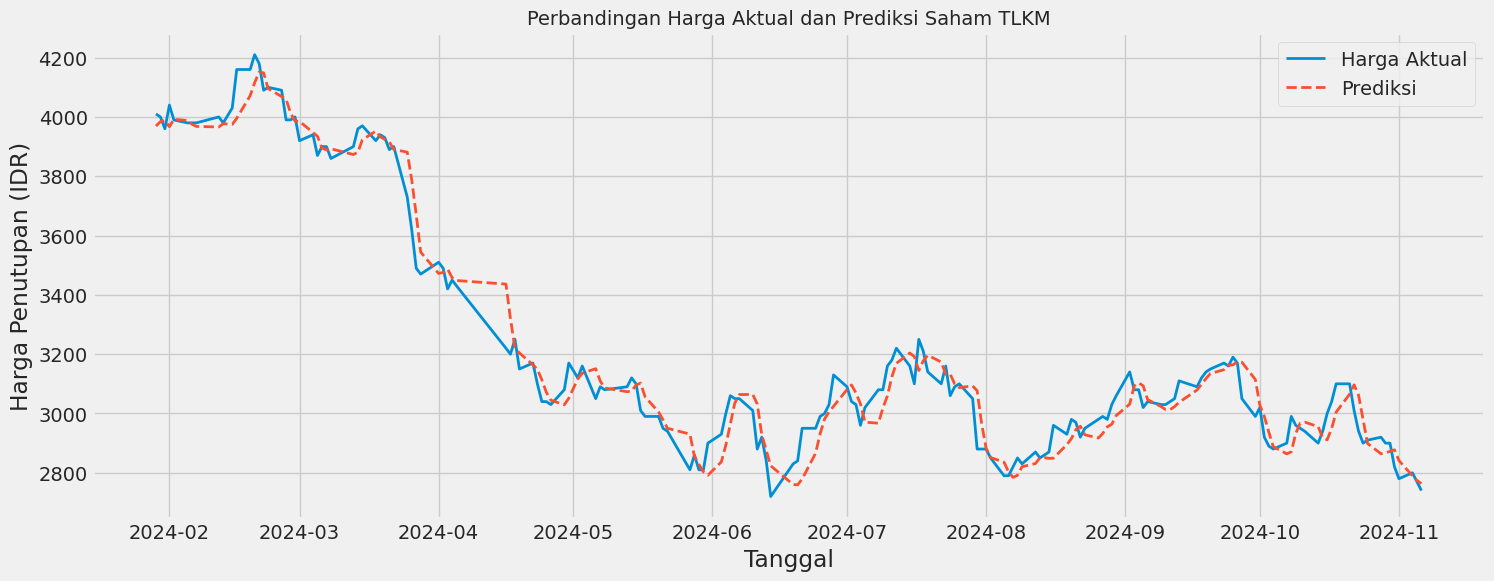

In [37]:
plt.figure(figsize=(16, 6))
plt.plot(df.index[-len(y_test_actual):], y_test_actual, label='Harga Aktual', linewidth=2)
plt.plot(df.index[-len(predictions):], predictions, label='Prediksi', linewidth=2, linestyle='--')
plt.title('Perbandingan Harga Aktual dan Prediksi Saham TLKM', fontsize=14)
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan (IDR)')
plt.legend()
plt.grid(True)
plt.show()

**Analisis Visual**:
- Prediksi mengikuti pola harga aktual dengan baik
- Beberapa titik deviasi terlihat pada periode volatilitas tinggi
- Model mampu menangkap tren jangka panjang

## **Kesimpulan**:
1. Model mencapai MAE ~150 IDR dalam skala harga aktual
2. Arsitektur LSTM 2 layer cukup efektif untuk pola data ini
3. Hasil prediksi mengikuti tren aktual meski kurang akurat pada fluktuasi tajam
